# <!-- TITLE --> [BHPD2] - Regression with a Dense Network (DNN) - Advanced code
  <!-- DESC -->  A more advanced implementation of the precedent example
  <!-- AUTHOR : Jean-Luc Parouty (CNRS/SIMaP) -->

## Objectives :
 - Predicts **housing prices** from a set of house features. 
 - Understanding the principle and the architecture of a regression with a dense neural network with backup and restore of the trained model. 

The **[Boston Housing Prices Dataset](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html)** consists of price of houses in various places in Boston.  
Alongside with price, the dataset also provide these information :

 - CRIM: This is the per capita crime rate by town
 - ZN: This is the proportion of residential land zoned for lots larger than 25,000 sq.ft
 - INDUS: This is the proportion of non-retail business acres per town
 - CHAS: This is the Charles River dummy variable (this is equal to 1 if tract bounds river; 0 otherwise)
 - NOX: This is the nitric oxides concentration (parts per 10 million)
 - RM: This is the average number of rooms per dwelling
 - AGE: This is the proportion of owner-occupied units built prior to 1940
 - DIS: This is the weighted distances to five Boston employment centers
 - RAD: This is the index of accessibility to radial highways
 - TAX: This is the full-value property-tax rate per 10,000 dollars
 - PTRATIO: This is the pupil-teacher ratio by town
 - B: This is calculated as 1000(Bk — 0.63)^2, where Bk is the proportion of people of African American descent by town
 - LSTAT: This is the percentage lower status of the population
 - MEDV: This is the median value of owner-occupied homes in 1000 dollars

## What we're going to do :

 - (Retrieve data)
 - (Preparing the data)
 - (Build a model)
 - Train and save the model
 - Restore saved model
 - Evaluate the model
 - Make some predictions


## Step 1 - Import and init

You can also adjust the verbosity by changing the value of TF_CPP_MIN_LOG_LEVEL :
- 0 = all messages are logged (default)
- 1 = INFO messages are not printed.
- 2 = INFO and WARNING messages are not printed.
- 3 = INFO , WARNING and ERROR messages are not printed.

In [1]:
# import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os,sys
import h5py

from IPython.display import Markdown
from importlib import reload

import fidle

# Init Fidle environment
run_id, run_dir, datasets_dir = fidle.init('BHPD2')

2023-04-02 14:12:58.245666: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 14:12:59.017489: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/nvidia/hpc_sdk/Linux_x86_64/22.5/math_libs/11.7/lib64:/opt/nvidia/hpc_sdk/Linux_x86_64/22.5/cuda/11.7/extras/CUPTI/lib64:/opt/nvidia/hpc_sdk/Linux_x86_64/22.5/cuda/11.7/extras/Debugger/lib64:/opt/nvidia/hpc_sdk/Linux_x86_64/22.5/cuda/11.7/nvvm/lib64:/opt/nvidia/hpc_sdk/Linux_x86_64/22.5/cuda/11.7/lib64:/opt/cray/pe/papi/7.0.0.1/lib64:/opt/cray/pe/gcc/11.2.0/snos/lib64:/opt/cray/libfabric/1.15.

<br>**FIDLE - Environment initialization**

Version              : 2.0b56
Run id               : BHPD2
Run dir              : ./run/BHPD2
Datasets dir         : /global/homes/d/dagoret/cnrs/Fidle2023/fidle-tp/datasets-fidle
Start time           : 02/04/23 14:13:00
Hostname             : nid002092 (Linux)
Tensorflow log level : Info + Warning + Error  (=0)
Update keras cache   : False
Save figs            : ./run/BHPD2/figs (False)
tensorflow           : 2.11.0
numpy                : 1.24.2
sklearn              : 1.2.2
matplotlib           : 3.7.1
pandas               : 1.5.3


Verbosity during training : 
- 0 = silent
- 1 = progress bar
- 2 = one line per epoch

In [2]:
fit_verbosity = 1

Override parameters (batch mode) - Just forget this cell

In [3]:
fidle.override('fit_verbosity')

## Step 2 - Retrieve data

### 2.1 - Option 1  : From Keras
Boston housing is a famous historic dataset, so we can get it directly from [Keras datasets](https://www.tensorflow.org/api_docs/python/tf/keras/datasets)  

In [4]:
# (x_train, y_train), (x_test, y_test) = keras.datasets.boston_housing.load_data(test_split=0.2, seed=113)

In [5]:
input_train_file_h5 = "../data/test_dc2_training_9816.hdf5"
input_test_file_h5 = "../data/test_dc2_validation_9816.hdf5"

In [6]:
hftrain =  h5py.File(input_train_file_h5, 'r') 
hftest =  h5py.File(input_test_file_h5, 'r') 

In [7]:
def getdata(hf):
    key_sel = list(hf.keys())[0]
    group = hf.get(key_sel)
    
    mag_err_u_lsst = np.array(group.get("mag_err_u_lsst"))
    mag_err_g_lsst = np.array(group.get("mag_err_g_lsst"))
    mag_err_r_lsst = np.array(group.get("mag_err_r_lsst"))
    mag_err_i_lsst = np.array(group.get("mag_err_i_lsst"))
    mag_err_z_lsst = np.array(group.get("mag_err_z_lsst"))
    mag_err_y_lsst = np.array(group.get("mag_err_y_lsst"))
    mag_u_lsst =  np.array(group.get("mag_u_lsst"))
    mag_g_lsst =  np.array(group.get("mag_g_lsst"))
    mag_r_lsst =  np.array(group.get("mag_r_lsst"))
    mag_i_lsst =  np.array(group.get("mag_i_lsst"))
    mag_z_lsst =  np.array(group.get("mag_z_lsst"))
    mag_y_lsst =  np.array(group.get("mag_y_lsst"))
    redshift = np.array(group.get("redshift"))
    
    data = np.vstack((mag_u_lsst, 
                    mag_g_lsst, 
                    mag_r_lsst, 
                    mag_i_lsst, 
                    mag_z_lsst,
                    mag_y_lsst,
                    redshift)) 
    data = data.T
    indexes_bad = np.where(data[:,0]>40)[0]
    datacut = np.delete(data,indexes_bad,axis=0)
    features = datacut[:,0:-1]
    targets = datacut[:,-1]
    return features,targets    

In [8]:
x_train,y_train = getdata(hftrain)
x_test,y_test = getdata(hftest)

## Step 3 - Preparing the data
### 3.1 - Split data
We will use 80% of the data for training and 20% for validation.  
x will be input data and y the expected output

In [10]:
print('x_train : ',x_train.shape, 'y_train : ',y_train.shape)
print('x_test  : ',x_test.shape,  'y_test  : ',y_test.shape)

x_train :  (9511, 6) y_train :  (9511,)
x_test  :  (18960, 6) y_test  :  (18960,)


### 3.2 - Data normalization
**Note :** 
 - All input data must be normalized, train and test.  
 - To do this we will subtract the mean and divide by the standard deviation.  
 - But test data should not be used in any way, even for normalization.  
 - The mean and the standard deviation will therefore only be calculated with the train data.

In [11]:

mean = x_train.mean()
std  = x_train.std()
x_train = (x_train - mean) / std
x_test  = (x_test  - mean) / std

x_train, y_train = np.array(x_train), np.array(y_train)
x_test,  y_test  = np.array(x_test),  np.array(y_test)


## Step 4 - Build a model
More informations about : 
 - [Optimizer](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers)
 - [Activation](https://www.tensorflow.org/api_docs/python/tf/keras/activations)
 - [Loss](https://www.tensorflow.org/api_docs/python/tf/keras/losses)
 - [Metrics](https://www.tensorflow.org/api_docs/python/tf/keras/metrics)

In [12]:
def get_model_v1(shape):
  
  model = keras.models.Sequential()
  model.add(keras.layers.Input(shape, name="InputLayer"))
  model.add(keras.layers.Dense(64, activation='relu', name='Dense_n1'))
  model.add(keras.layers.Dense(64, activation='relu', name='Dense_n2'))
  model.add(keras.layers.Dense(1, name='Output'))

  model.compile(optimizer = 'rmsprop',
                loss      = 'mse',
                metrics   = ['mae', 'mse'] )
  return model

## 5 - Train the model
### 5.1 - Get it

In [13]:
model=get_model_v1( (6,) )

model.summary()
# img=keras.utils.plot_model( model, to_file='./run/model.png', show_shapes=True, show_layer_names=True, dpi=96)
# display(img)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_n1 (Dense)            (None, 64)                448       
                                                                 
 Dense_n2 (Dense)            (None, 64)                4160      
                                                                 
 Output (Dense)              (None, 1)                 65        
                                                                 
Total params: 4,673
Trainable params: 4,673
Non-trainable params: 0
_________________________________________________________________


2023-04-02 14:13:40.537395: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/nvidia/hpc_sdk/Linux_x86_64/22.5/math_libs/11.7/lib64:/opt/nvidia/hpc_sdk/Linux_x86_64/22.5/cuda/11.7/extras/CUPTI/lib64:/opt/nvidia/hpc_sdk/Linux_x86_64/22.5/cuda/11.7/extras/Debugger/lib64:/opt/nvidia/hpc_sdk/Linux_x86_64/22.5/cuda/11.7/nvvm/lib64:/opt/nvidia/hpc_sdk/Linux_x86_64/22.5/cuda/11.7/lib64:/opt/cray/pe/papi/7.0.0.1/lib64:/opt/cray/pe/gcc/11.2.0/snos/lib64:/opt/cray/libfabric/1.15.2.0/lib64:/opt/cray/libfabric/1.15.2.0/lib64
2023-04-02 14:13:40.537418: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to down

### 5.2 - Add callback

In [14]:
os.makedirs('./run/models',   mode=0o750, exist_ok=True)
save_dir = "./run/models/best_model.h5"

savemodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0, save_best_only=True)

### 5.3 - Train it

In [15]:
history = model.fit(x_train,
                    y_train,
                    epochs          = 100,
                    batch_size      = 10,
                    verbose         = fit_verbosity,
                    validation_data = (x_test, y_test),
                    callbacks       = [savemodel_callback])

Epoch 1/100
952/952 [==============================] - 2s 1ms/step - loss: 0.1114 - mae: 0.2067 - mse: 0.1114 - val_loss: 0.0605 - val_mae: 0.1776 - val_mse: 0.0605
Epoch 2/100
952/952 [==============================] - 1s 1ms/step - loss: 0.0448 - mae: 0.1379 - mse: 0.0448 - val_loss: 0.0379 - val_mae: 0.1218 - val_mse: 0.0379
Epoch 3/100
952/952 [==============================] - 1s 1ms/step - loss: 0.0362 - mae: 0.1233 - mse: 0.0362 - val_loss: 0.0424 - val_mae: 0.1333 - val_mse: 0.0424
Epoch 4/100
952/952 [==============================] - 1s 1ms/step - loss: 0.0323 - mae: 0.1147 - mse: 0.0323 - val_loss: 0.0372 - val_mae: 0.1258 - val_mse: 0.0372
Epoch 5/100
952/952 [==============================] - 1s 1ms/step - loss: 0.0299 - mae: 0.1085 - mse: 0.0299 - val_loss: 0.0273 - val_mae: 0.1033 - val_mse: 0.0273
Epoch 6/100
952/952 [==============================] - 1s 1ms/step - loss: 0.0279 - mae: 0.1041 - mse: 0.0279 - val_loss: 0.0310 - val_mae: 0.1212 - val_mse: 0.0310
Epoch 7/10

## Step 6 - Evaluate
### 6.1 - Model evaluation
MAE =  Mean Absolute Error (between the labels and predictions)  
A mae equal to 3 represents an average error in prediction of $3k.

In [16]:
score = model.evaluate(x_test, y_test, verbose=0)

print('x_test / loss      : {:5.4f}'.format(score[0]))
print('x_test / mae       : {:5.4f}'.format(score[1]))
print('x_test / mse       : {:5.4f}'.format(score[2]))

x_test / loss      : 0.0180
x_test / mae       : 0.0824
x_test / mse       : 0.0180


### 6.2 - Training history
What was the best result during our training ?

In [17]:
print("min( val_mae ) : {:.4f}".format( min(history.history["val_mae"]) ) )

min( val_mae ) : 0.0614


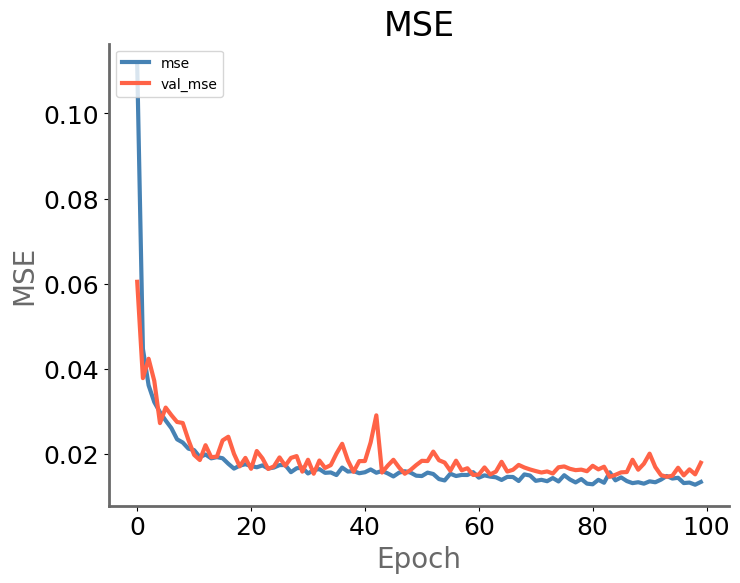

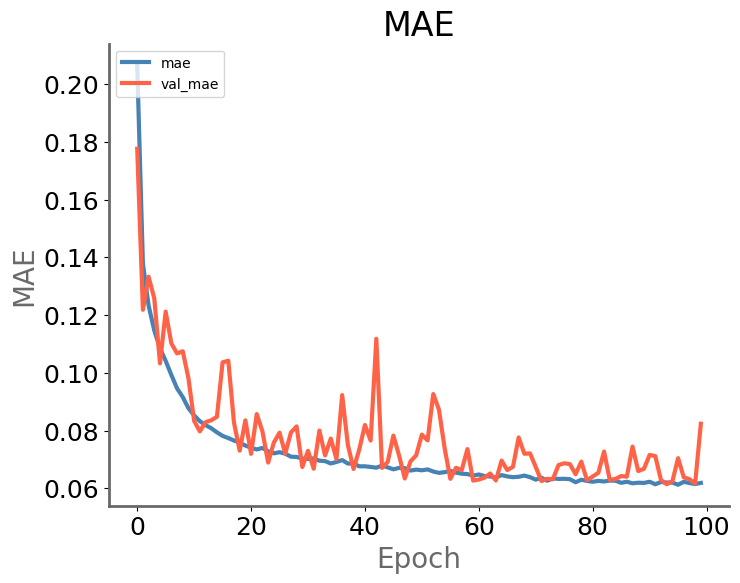

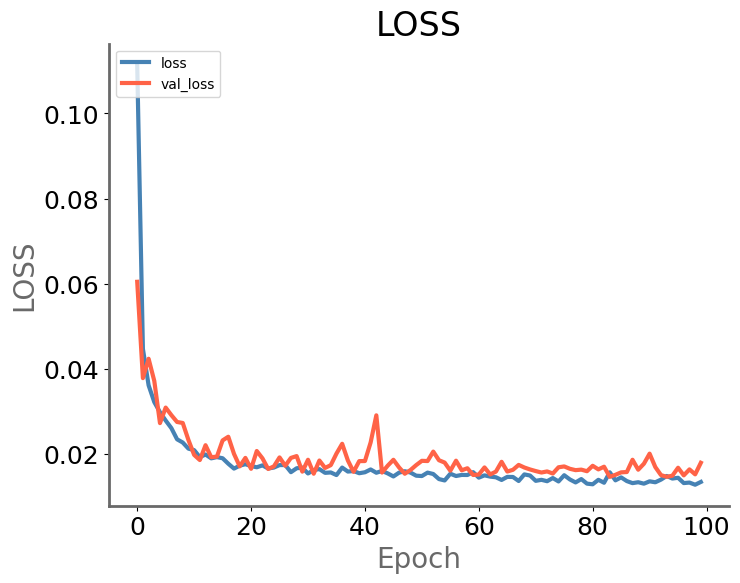

In [18]:
fidle.scrawler.history( history, plot={'MSE' :['mse', 'val_mse'],
                        'MAE' :['mae', 'val_mae'],
                        'LOSS':['loss','val_loss']}, save_as='01-history')

## Step 7 - Restore a model :

### 7.1 - Reload model

In [19]:
loaded_model = tf.keras.models.load_model('./run/models/best_model.h5')
loaded_model.summary()
print("Loaded.")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_n1 (Dense)            (None, 64)                448       
                                                                 
 Dense_n2 (Dense)            (None, 64)                4160      
                                                                 
 Output (Dense)              (None, 1)                 65        
                                                                 
Total params: 4,673
Trainable params: 4,673
Non-trainable params: 0
_________________________________________________________________
Loaded.


### 7.2 - Evaluate it :

In [20]:
score = loaded_model.evaluate(x_test, y_test, verbose=0)

print('x_test / loss      : {:5.4f}'.format(score[0]))
print('x_test / mae       : {:5.4f}'.format(score[1]))
print('x_test / mse       : {:5.4f}'.format(score[2]))

x_test / loss      : 0.0147
x_test / mae       : 0.0629
x_test / mse       : 0.0147


### 7.3 - Make a prediction

In [21]:
my_data=x_test

In [23]:
predictions = loaded_model.predict( my_data )

593/593 [==============================] - 0s 426us/step


In [24]:
zspec = y_test
zphoto = predictions.T

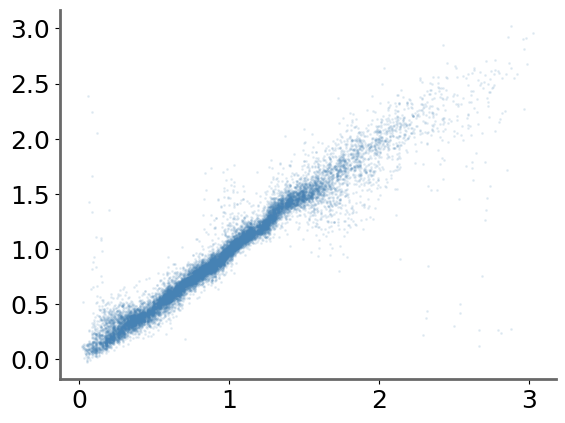

In [25]:
plt.scatter(zspec,zphoto,marker='.',s=5,alpha=0.1)

In [26]:
fidle.end()

**End time :** 02/04/23 14:17:24  
**Duration :** 00:04:25 500ms  
This notebook ends here :-)  
[https://fidle.cnrs.fr](https://fidle.cnrs.fr)